In [1]:
import warnings
warnings.simplefilter("ignore")
import numpy as np
from scipy import integrate
import matplotlib.pylab as pylab
import pandas as pd
from functools import partial
import models

# $\psi(\phi)$ of FT Model

<Axes: >

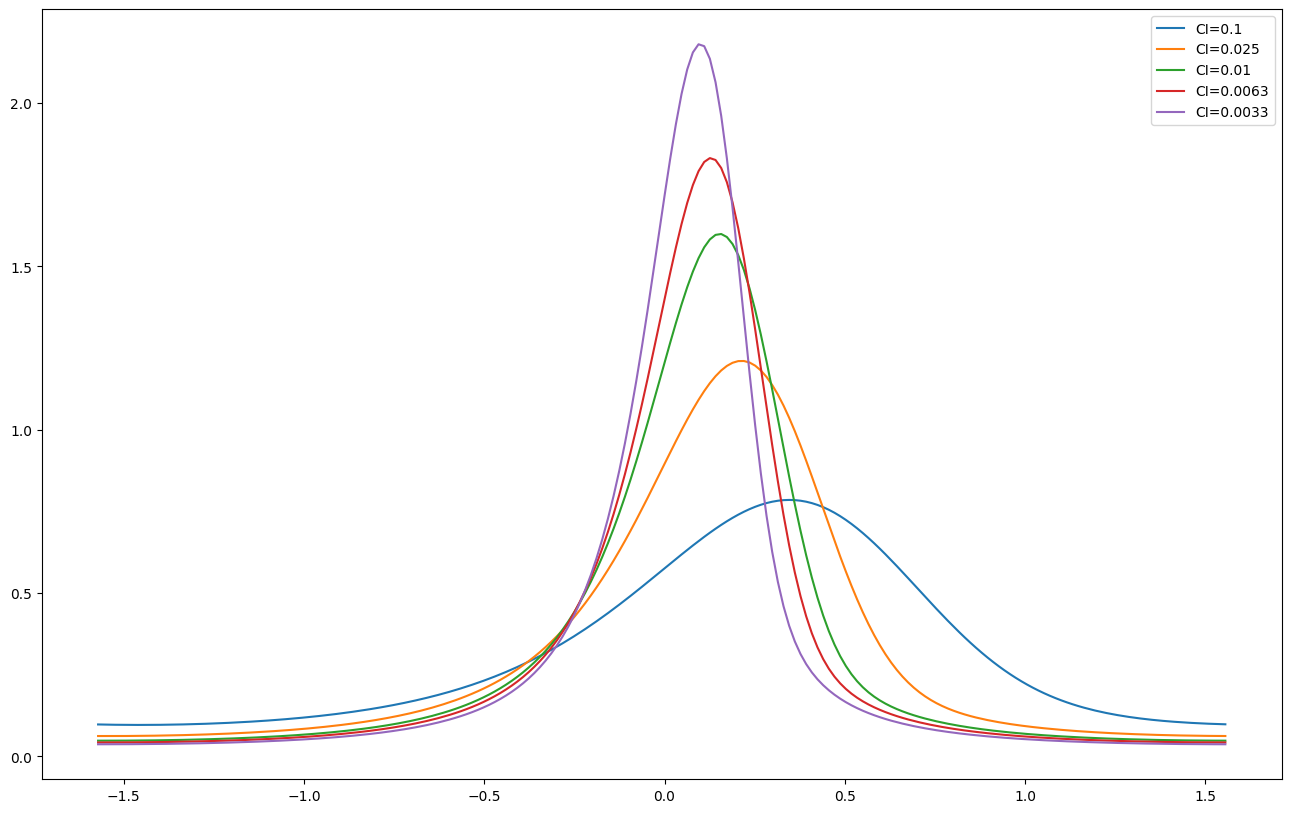

In [2]:
from functools import partial
rho=11.8
df=pd.DataFrame()
for CI in [0.1,0.025,0.01,0.0063,0.0033]:
    phi=np.arange(-np.pi/2,np.pi/2,np.pi/200,dtype=np.float64)
    # initial state random oriented
    psi_0=np.array([1/np.pi]*len(phi))
    shear_rate=1
    fun=partial(models.FT_model_analytic_psi.dpsi_pt,rho=rho,phi=phi,CI=CI,shear_rate=shear_rate)
    tspan=(0,100)
    t_eval=np.linspace(0,tspan[1])
    res=integrate.solve_ivp(fun,tspan,psi_0,method='LSODA',t_eval=t_eval)
    res_df=pd.DataFrame(res['y'],index=phi)
    #res_df.plot(y=[1,49])
    df.loc[:,'CI='+str(CI)]=res_df.loc[:,20]
df.plot(figsize=[16,10])

# Single fiber rotation trajectories $\phi(\gamma)$ of FT Model

CI=0.01 rho=11.8


<Axes: xlabel='angle'>

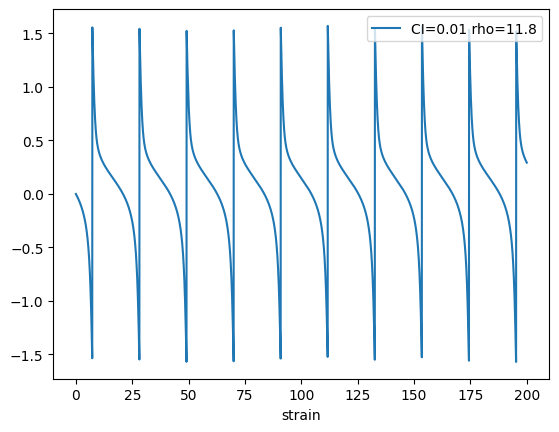

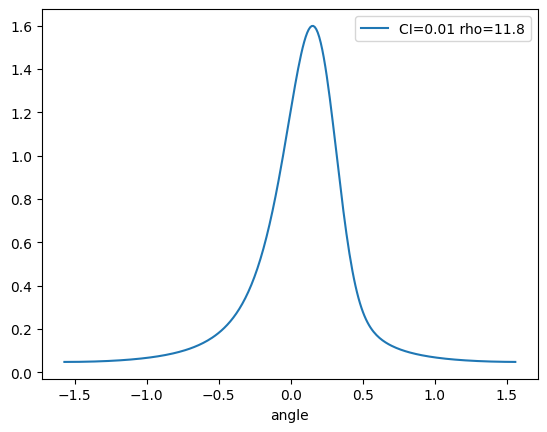

In [3]:
from scipy.signal import find_peaks
#container of the stable psi 
psi_df=pd.DataFrame()
#container of the phi versus strain
phi_df=pd.DataFrame()
period_df=pd.DataFrame()
period_df.index.name='rho'
period_df.columns.name='CI'
for rho in [11.8]:
#for rho in [3,5,10,15,20,30,50]:
    #for CI in [0.1,0.025,0.0111,0.0063,0.0033,0.0016,0.0008,0.0004,0.0002,0.0001]:
    for CI in [0.01]:
        # calculate psi_stable
        phi_span=np.arange(-np.pi/2,np.pi/2,np.pi/300,dtype=np.float64)
        psi_0=np.array([1/np.pi]*len(phi_span))
        shear_rate=1
        fun=partial(models.FT_model_analytic_psi.dpsi_pt,rho=rho,phi=phi_span,CI=CI,shear_rate=shear_rate)
        tspan=(0,100)
        t_eval=np.linspace(0,tspan[1])
        res=integrate.solve_ivp(fun,tspan,psi_0,method='LSODA',t_eval=t_eval)
        psi_stable=res['y'][:,-1]
        psi_df.loc[:,'CI='+str(CI)+' rho='+str(rho)]=psi_stable
        
        from scipy.interpolate import interp1d
        phi_span_interp=np.concatenate((phi_span-np.pi,phi_span,phi_span+np.pi))
        psi_stable_interp=np.concatenate((psi_stable,psi_stable,psi_stable))
        psi_stable_interp_fun=interp1d(phi_span_interp,psi_stable_interp,kind='cubic')

        # calculate the rotation of the fiber
        rotation_fun=partial(models.FT_model_analytic_psi.dphi_dt,rho=rho,psi_stable_interp_fun=psi_stable_interp_fun,CI=CI,shear_rate=shear_rate)
        tspan=(0,200)
        phi_0=np.array([0,])
        t_eval=np.linspace(0,tspan[1],num=4000)
        res=integrate.solve_ivp(rotation_fun,tspan,phi_0,method='LSODA',max_step=0.2,t_eval=t_eval)
        phi=res['y'][0,:]
        phi=(phi+np.pi/2)%np.pi-np.pi/2
        phi_df.loc[:,'CI='+str(CI)+' rho='+str(rho)]=phi
        
        print('CI='+str(CI)+' rho='+str(rho))
        p,_=find_peaks(np.abs(phi))
        period_df.loc[rho,CI]=4*p[0]/4000*200        
phi_df.index=t_eval*shear_rate
phi_df.index.name='strain'
psi_df.index=phi_span
psi_df.index.name='angle'
#plot results
phi_df.plot()
psi_df.plot()